## **Lightweight Reinforcement Algorithms for Autonomous, Scalable, Neuromorphic intra-cortical Brain Machine Interfaces**

This work discusses the application of five popular online RL algorithms in the context of intention decoders for iBMI systems. RL based iBMI implementations are promising as they tackle the issue of frequent re-training and calibrations; also they adopt an online learning strategy, which is resonant with ‘how the brain performs.’ We compare the discrete-state decoding performances of online learning RL algorithms like **Banditron**, and **Banditron-RP (proposed)** against state-of-the-art batch-training based RL algorithms like **Attention Gate Reinforcement Learning (AGREL)**, **Hebbian Reinforcement Learning (HRL)**, and **Deep Q-Learning**. 

\\
**Dataset used:** The datasets are recorded in-house at A*star. A total of four datasets, two from NHP A (experiments 1 and 3) and two from NHP B (experiments 2 and 4) respectively. Here we have evaluated on a small publicly available [dataset](https://osf.io/dce96/).

\\
**Performance metric:** Classification accuracy (decoding accuracy)

**Reference:** Ghosh A., and Shaikh S. et al., Lightweight Reinforcement Learning Decoders for Autonomous, Scalable, Neuromorphic intra-cortical Brain Machine Interface; submitted Neuromorphic Computing & Interface, 2023.

\\
**Version:** v1.0

**License:** Please see the accompanying file named "LICENSE"

**Author:** Aayushman Ghosh, University of Illinois Urbana Champaign, May 2023. (<aghosh14@illinois.edu>)

In [8]:
# Importing the necessary libraries and modules.
import warnings
warnings.filterwarnings('ignore')
import numpy as np
from scipy.io import loadmat
import pandas as pd
import os
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
import time
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras.layers import Dense, BatchNormalization
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.activations import relu
from tensorflow.keras import Model, Input
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.metrics import Accuracy
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.models import load_model, Sequential
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from lightgbm import LGBMRegressor
from sklearn.multioutput import MultiOutputRegressor
import scipy.special as sp

scaler = StandardScaler()

In [22]:
# Defining the Global Variables --> Directory, error and sparsity error.
dir = r'/content/drive/MyDrive/Datasets/BMI_datasets/classification_dataset/monkey_2_set_2' # Parent directory that contain the processed classification files.

error = 0             # Defining the error in Feedback
sparsity_rate = 0     # Sparsity in the Feedback signals

In [23]:
# Mounting the google drive to load the dataset as needed.
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [11]:
# Defining the sigmoid function.
def sigmoid(x):
  z = 1/(1+sp.expit(-x))
  return z

In [13]:
# Defining the ReLU function.
def ReLU(x):
  z = np.maximum(0,x)
  return z

In [14]:
# Defining the softmax function.
def softmax(x):
  x = x - np.max(x)
  z = np.exp(x)/np.sum(np.exp(x))
  return z

In [15]:
# Defining the Banditron Function (Single Layered Network)
'''
Here, **kwargs is used to denote the arbitary input functions. The error and sparse_rate
corresponds to the error and the sparsity introduced to the feedback signal (refer to the 
paper to understand the physical significance). k denotes the number of classes and is 
fixed at 4 for our experiments. X denotes the spike count data (observation -- input dataset) 
and y denotes the true labels associated with each observation (X) 
'''
def banditron(X, y, error, sparse_rate, k=4, **kwargs):
    T = X.shape[0] 
    d = X.shape[1]
    np.random.seed(100) 
    W = np.zeros((k, d)) # Initializing the Weight Matrix. 
    error_count = np.zeros(T) 
    pred = [] # The predicted labels will be stored here.
    
    # The exploration exploitation constant and eta are given as optional arguments.
    if "gammas" not in kwargs:
        gammas = [kwargs["gamma"] for i in range(T)]
    else:
        gammas = kwargs["gammas"]
    
    if "eta" in kwargs:
        eta = kwargs["eta"]
    
    # Evaluative framework (refer to the paper to understand the mathematics)
    for t in range(T):
        gamma = gammas[t]
        y_hat = np.argmax(np.dot(W, X[t]))
        p = [gamma/k for i in range(k)]
        p[y_hat] = p[y_hat] + 1 - gamma
        y_tilde = np.random.choice(range(k), p=p)
        pred.append(y_tilde)
        sparsify = np.random.choice([True,False],p=[sparse_rate,1-sparse_rate])
        if not sparsify:
          if y_tilde != y[t]:
            choice = np.random.choice(range(2),p=[error,1-error])
            if choice == 1:
              W[y_hat] = W[y_hat] - X[t]   
            else:
              W[y_hat] = W[y_hat] - X[t]
              W[y_tilde] = W[y_tilde] + X[t] / p[y_tilde]         
          else:
            choice = np.random.choice(range(2),p=[error,1-error])
            if choice == 1:
              W[y_hat] = W[y_hat] - X[t]
              W[y_tilde] = W[y_tilde] + X[t] / p[y_tilde]
            else:
              W[y_hat] = W[y_hat] - X[t]       
    return pred

In [16]:
# Defining the Banditron-RP Function (Three Layered Network)
'''
Here, **kwargs is used to denote the arbitary input functions. The error and sparse_rate
corresponds to the error and the sparsity introduced to the feedback signal (refer to the 
paper to understand the physical significance). k denotes the number of classes and is 
fixed at 4 for our experiments. X denotes the spike count data (observation -- input dataset) 
and y denotes the true labels associated with each observation (X) 
'''
def banditronRP(X, y, k, error, sparse_rate, **kwargs):
    d = X.shape[1]
    Wrand = np.random.uniform(size=(k,d)) # The random Weight matrix generated from a normal distribution.
    f = sigmoid(np.dot(Wrand,X.T)) # The non-linear projection vector input to the hidden layer.
    pred = banditron(f.T, y, error, sparsity_rate, **kwargs) # f(t) = Sigmoid(Wrand.x(t)) is given as an input to the Banditron.
    return pred

In [17]:
# Defining the HRL function (Three Layered Network)
# Initializing the weight matrices
'''
In HRL the weight matrices are not initialized as zero matrix instead random floats
are extracted from Gaussian Distribution (mean = 0, var = 1). Here inp_shp denotes the
number of rows, and out_shp the number of columns for the weight matrix.
'''
def initialize(inp_shp,out_shp):
  W = np.random.randn(out_shp,inp_shp)
  return W

'''
The error and sparse_rate corresponds to the error and the sparsity introduced to the 
feedback signal (refer to the paper to understand the physical significance). muH and muO
denotes the learning rates corresponding to the weight updation policy. num_nodes is a matrix referring to 
the number of hidden nodes and output nodes. X denotes the spike count data (observation -- input dataset) 
and y denotes the true labels associated with each observation (X) 
'''  
def HRL(X, y, muH, muO, num_nodes, error, sparse_rate):
    T = X.shape[0]
    W = [0]*(len(num_nodes)-1)
    pred = []
    num_nodes[0] = num_nodes[0]+1
    
    # Initializing the weight matrices.
    for i in range(1,len(num_nodes)):
      W[i-1] = initialize(num_nodes[i-1],num_nodes[i])
    
    # Computing the output for the hidden layer and output layer.
    for t in range(T):
      x = np.insert(X[t],0,1)
      out = [x.reshape(-1,1)]*(len(num_nodes))     
      for i in range(1,len(num_nodes)):
        out[i] = np.tanh(np.dot(W[i-1],out[i-1]))
      
      # Evaluative framework (refer to the paper to understand the mathematics)
      out[-1] = np.tanh(np.dot(W[-1],np.sign(out[-2])))
      yhat = np.argmax(out[-1])
      sparsify = np.random.choice([True,False],p=[sparse_rate,1-sparse_rate])
      if not sparsify:
        if yhat == y[t]:
          f = np.random.choice([-1,1],p=[error,1-error])
        else:
          f = np.random.choice([1,-1],p=[error,1-error])
        dW = [0]*(len(num_nodes)-1)
  
        for i in range(1,len(num_nodes)):
          dW[i-1] = muH*f*(np.dot((np.sign(out[i])-out[i]),out[i-1].T)) + muH*(1-f)*(np.dot((1-np.sign(out[i])-out[i]),out[i-1].T))
          W[i-1] = W[i-1] + dW[i-1]

        dW[-1] = muO*f*(np.dot((np.sign(out[-1])-out[-1]),out[-2].T)) + muO*(1-f)*(np.dot((1-np.sign(out[-1])-out[-1]),out[-2].T))
        W[-1] = W[-1] + dW[-1]

      pred.append(yhat)
    return pred

In [18]:
# Defining the AGREL function (Three Layered Network)
# Initializing the weight matrices
'''
In AGREL the weight matrices are not initialized as zero matrix instead random floats
are extracted from Gaussian Distribution (mean = 0, var = 1). Here inp_shp denotes the
number of rows, and out_shp the number of columns for the weight matrix.
'''
def initialize(inp_shp,out_shp):
  W = np.random.uniform(low=-1,high=1,size=(out_shp,inp_shp))
  return W

'''
The error and sparse_rate corresponds to the error and the sparsity introduced to the 
feedback signal (refer to the paper to understand the physical significance). alpha, and beta
denotes the learning rates corresponding to the weight updation policy. num_nodes is a matrix referring to 
the number of hidden nodes and output nodes. gamma denotes the exploration-exploitation trade-off. 
X denotes the spike count data (observation -- input dataset) and y denotes the true labels associated with each observation (X) 
''' 
def AGREL(X, y, gamma, alpha, beta, num_nodes, error, sparse_rate):
    T = X.shape[0]
    pred = []
    
    # Initializing the weight matrices.
    W_H = initialize(num_nodes[0]+1,num_nodes[1])
    W_O = initialize(num_nodes[1],num_nodes[2])

    for t in range(T):
      x = np.insert(X[t],0,1).reshape(-1,1) 
      y_H = sigmoid(np.dot(W_H,x))
      Z = np.dot(W_O,y_H)
      y_O = softmax(Z)
      yhat = np.argmax(y_O)
      
      # Computing the output for the hidden layer and output layer.
      outs = np.zeros(Z.shape)
      outs[yhat] = 1
      explore = np.random.uniform()<gamma 
      
      # Evaluative framework (refer to the paper to understand the mathematics)
      if explore:
        y_tilde = np.random.randint(low=0,high=num_nodes[-1])
      else:
        y_tilde = yhat
      sparsify = np.random.choice([True,False],p=[sparse_rate,1-sparse_rate])
      if not sparsify:
        if y_tilde == y[t]:
          delta = np.random.choice([-1 ,1 - outs[y_tilde]],p=[error,1-error])
        else:
          delta = np.random.choice([-1 ,1 - outs[y_tilde]],p=[1-error,error])
        '''
        In AGREL, δ therefore influences plasticity through
        an expansive function f (δ), which also helps to fasten
        the learning process. f (δ) is defined such as, it takes
        large values if δ is close to 1, that is, when actions are
        rewarded unexpectedly.
        '''
        if delta >= 0:
          f = delta/(1-delta+1e-4) 
        else:
          f = delta
        # Weight updation policy of AGREL
        dW_O = beta*f*y_H.T
        dW_H = alpha*f*np.dot((y_H*(1-y_H)*W_O[y_tilde,:].reshape(-1,1)),x.T)

        W_O[y_tilde,:] = W_O[y_tilde,:] + dW_O
        W_H = W_H + dW_H
        
      pred.append(yhat)
    return pred

In [19]:
# Defining the DQN function (Four Layered Network)
# Defining the DQN model
'''
Here, the Deep Q Learning model is computed as a four layer network, where the number of
nodes in the input layer changes with the experiment, and is given by inp_shp. This 
following function sequentially builds the model, where the output layer has 4 classes,
and the two hidden layers has 128 neurons.
'''
def get_DQN_model(inp_shp, lr=0.01):
  np.random.seed(101)
  model = Sequential()
  model.add(Dense(128, activation='relu', input_shape=(inp_shp,))) # hidden layer1 neurons = 128
  model.add(Dense(128, activation='relu')) # hidden layer2 neurons = 128
  model.add(Dense(4, activation='linear')) # Output layer neurons = 4
  model.compile(loss='mse',optimizer='adam') # A mse loss function is used with an adam optimizer.
  return model

'''
The error and sparse_rate corresponds to the error and the sparsity introduced to the 
feedback signal (refer to the paper to understand the physical significance). epsilon and gamma 
denotes the exploration constant and discount factor. X denotes the spike count data 
(observation -- input dataset) and y denotes the true labels associated with each observation (X). 
'''
def DQN(X,Y,epsilon,gamma,error,sparse_rate):

  inp_shp = X.shape[1] # Number of electrodes --> corresponding to the no. of neurons in the first layer.
  model = get_DQN_model(inp_shp)
  T = X.shape[0]
  X_norm = scaler.fit_transform(X)
  pred = []
  
  # Evaluative framework (refer to the paper to understand the mathematics)
  for t in range(T):
    x = X_norm[t,:].reshape(1,X.shape[1]).astype(np.float32)
    y = Y[t,:].reshape(1,Y.shape[1])
    Q = model.predict(x)

    yhat = np.argmax(Q)
    explore = np.random.uniform() < epsilon
    if explore:
      ytilde = np.random.randint(low=0,high=4)
    else:
      ytilde = yhat
    sparsify = np.random.choice([True,False],p=[sparse_rate,1-sparse_rate])
    if not sparsify:
      if ytilde == np.argmax(y):
        r = np.random.choice([-1 ,1],p=[error,1-error])
      else:
        r = np.random.choice([1 ,-1],p=[error,1-error])

      Target = r + gamma*np.amax(Q)
      Target_vec = Q
      Target_vec[0,ytilde] = Target
      Target_vec = np.array(Target_vec).reshape(1,4)

      model.fit(x,Target_vec,batch_size=1, epochs=1,verbose=0)

    pred.append(ytilde)
  return np.array(pred)

In [20]:
# Defining the LGBM based Q-Learning Function
# Building the LGBM Model
'''
Here, instead of using a deep neural network to build the DQN framework, we have 
used the LightGBM framework with a Q-Learning policy. We call this model the QLGBM Network.
'''
def get_QLGBM_model():
  model = MultiOutputRegressor(LGBMRegressor(n_jobs=-1)) 
  return model

'''
The error and sparse_rate corresponds to the error and the sparsity introduced to the 
feedback signal (refer to the paper to understand the physical significance). epsilon and gamma 
denotes the exploration constant and discount factor. X denotes the spike count data 
(observation -- input dataset) and y denotes the true labels associated with each observation (X). 
'''
def QLGBM(X,Y,epsilon,gamma,error,sparse_rate):
  model = get_QLGBM_model()
  T = X.shape[0]
  X_norm = scaler.fit_transform(X)
  pred = []
  isFit = False
  
  # Evaluative framework (refer to the paper to understand the mathematics)
  for t in range(T-1):
    x = X_norm[t:t+2,:].astype(np.float32)
    y = Y[t:t+2,:]
    if isFit:
      Q = model.predict(x)
    else:
      np.random.seed(101)
      Q = np.random.uniform(low=-1,high=1,size=(2,4))
    yhat = np.argmax(Q[0,:])
    explore = np.random.uniform() < epsilon
    if explore:
      ytilde = np.random.randint(low=0,high=4)
    else:
      ytilde = yhat
    sparsify = np.random.choice([True,False],p=[sparse_rate,1-sparse_rate])
    if not sparsify:
      if ytilde == np.argmax(y):
        r = np.random.choice([-1 ,1],p=[error,1-error])
      else:
        r = np.random.choice([1 ,-1],p=[error,1-error])
      Target = r + gamma*np.amax(Q)
      Target_vec = Q
      Target_vec[0,ytilde] = Target
      Target_vec = np.array(Target_vec).reshape(2,4)
      model.fit(x,Target_vec)
      isFit = True
    pred.append(ytilde)
  return np.array(pred)

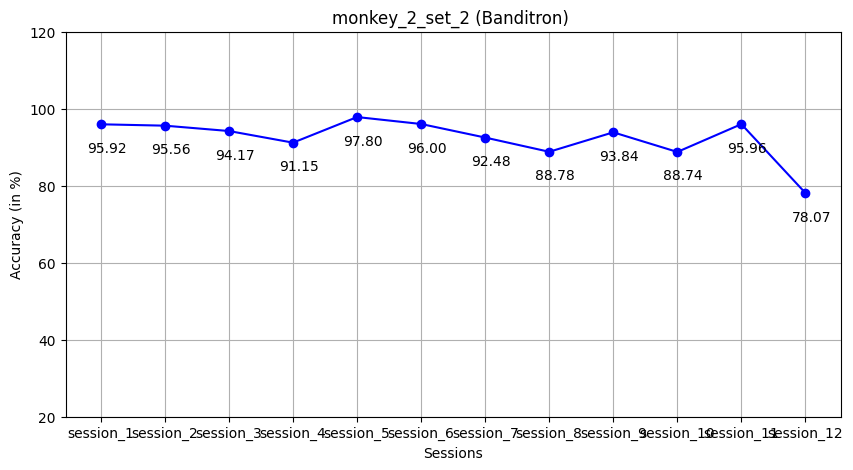

92.3703157153223


In [24]:
# Evaluating the Banditron Algorithm
directory = dir
files = os.listdir(directory)
acc = []
error_acc = []
interval = []
'''
Defining the Exploration constant 
'''
gamma = 0.0001 

for file in files:
    data = loadmat(os.path.join(directory,file))
    feature_mat = data["feature_mat"]
    X = feature_mat[:,:-1]
    y = feature_mat[:,-1]//90
    pred = banditron(X, y, error, sparsity_rate, gamma=gamma)
    results = np.vstack([y*90,np.array(pred)*90]).T
    results_df = pd.DataFrame(results,columns=["True","Pred"])
    error_intervals = 1/(np.sum(results_df.loc[:,"True"] == results_df.loc[:,"Pred"])/results_df.shape[0]*100)
    error_acc.append(error_intervals)
    interval.append(2.58*np.sqrt(error_intervals*(1-error_intervals))/results_df.shape[0])
    acc.append((np.sum(results_df.loc[:,"True"] == results_df.loc[:,"Pred"])/results_df.shape[0])*100)

acc_Banditron = acc
plt.figure(figsize=(10,5))
plt.plot(range(1,len(files)+1),acc,'b-o')
plt.grid()
plt.ylim((20,120))
plt.ylabel('Accuracy (in %)')
plt.xlabel('Sessions')
plt.xticks(range(1,len(files)+1), labels=['session_'+str(i) for i in range(1,len(files)+1)])
for x,y in zip(range(1,len(files)+1),acc):
    label = "{:.2f}".format(y)
    plt.annotate(label, # this is the text
                 (x,y), # these are the coordinates to position the label
                 textcoords="offset points", # how to position the text
                 xytext=(-10,-20)) # distance from text to points (x,y)
                 
plt.title(directory.split('/')[-1]+' (Banditron) ')
plt.show()
print(np.mean(acc_Banditron))

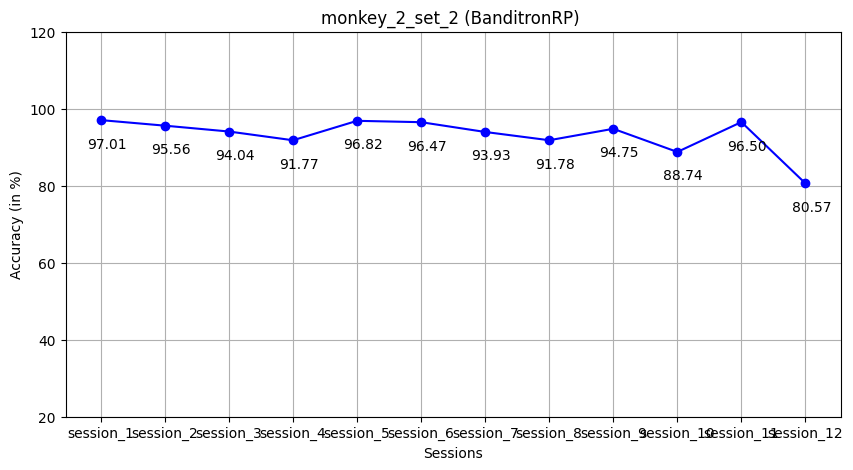

93.16043114109404


In [25]:
# Evaluating the Banditron-RP Algorithm
directory = dir
files = os.listdir(directory)
acc = []

for file in files:
    data = loadmat(os.path.join(directory,file))
    feature_mat = data["feature_mat"]
    X = feature_mat[:,:-1]
    y = feature_mat[:,-1]//90
    pred = banditronRP(X, y, 128, error, sparsity_rate, gamma=gamma)
    results = np.vstack([y*90,np.array(pred)*90]).T
    results_df = pd.DataFrame(results,columns=["True","Pred"])
    acc.append((np.sum(results_df.loc[:,"True"] == results_df.loc[:,"Pred"])/results_df.shape[0])*100)

acc_BanditronRP = acc
plt.figure(figsize=(10,5))
plt.plot(range(1,len(files)+1),acc,'b-o')
plt.grid()
plt.ylim((20,120))
plt.ylabel('Accuracy (in %)')
plt.xlabel('Sessions')
plt.xticks(range(1,len(files)+1), labels=['session_'+str(i) for i in range(1,len(files)+1)])
for x,y in zip(range(1,len(files)+1),acc):
    label = "{:.2f}".format(y)
    plt.annotate(label, # this is the text
                 (x,y), # these are the coordinates to position the label
                 textcoords="offset points", # how to position the text
                 xytext=(-10,-20)) # distance from text to points (x,y)
                 
plt.title(directory.split('/')[-1]+' (BanditronRP) ')
plt.show()
print(np.mean(acc_BanditronRP))

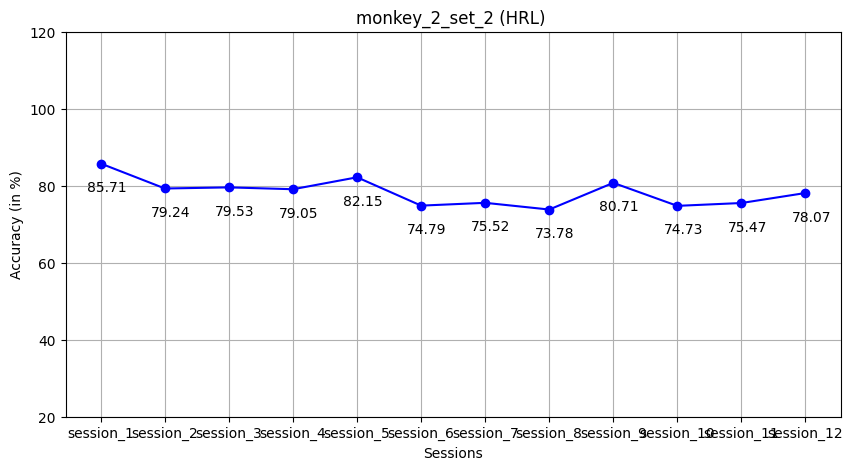

In [26]:
# Evaluating the HRL Algorithm
directory = dir
files = os.listdir(directory)
acc = []
muH = 0.01         # Hidden Layer Learning rate
muO = 0.01        # Output Layer Learning rate
num_nodes=[100,4]   # Hidden Layer Node sizes

for file in files:
    data = loadmat(os.path.join(directory,file))
    feature_mat = data["feature_mat"]
    X = feature_mat[:,:-1]
    y = feature_mat[:,-1]//90
    num_nodes=[75,4]
    num_nodes.insert(0,X.shape[1])
    pred = HRL(X, y, muH, muO, num_nodes, error, sparsity_rate)
    results = np.vstack([y*90,np.array(pred)*90]).T
    results_df = pd.DataFrame(results,columns=["True","Pred"])
    acc.append((np.sum(results_df.loc[:,"True"] == results_df.loc[:,"Pred"])/results_df.shape[0])*100)

acc_HRL = acc
plt.figure(figsize=(10,5))
plt.plot(range(1,len(files)+1),acc,'b-o')
plt.grid()
plt.ylim((20,120))
plt.ylabel('Accuracy (in %)')
plt.xlabel('Sessions')
plt.xticks(range(1,len(files)+1), labels=['session_'+str(i) for i in range(1,len(files)+1)])
for x,y in zip(range(1,len(files)+1),acc):
    label = "{:.2f}".format(y)
    plt.annotate(label, # this is the text
                 (x,y), # these are the coordinates to position the label
                 textcoords="offset points", # how to position the text
                 xytext=(-10,-20)) # distance from text to points (x,y)
                 
plt.title(directory.split('/')[-1]+' (HRL) ')
plt.show()
print(np.mean(acc_HRL))

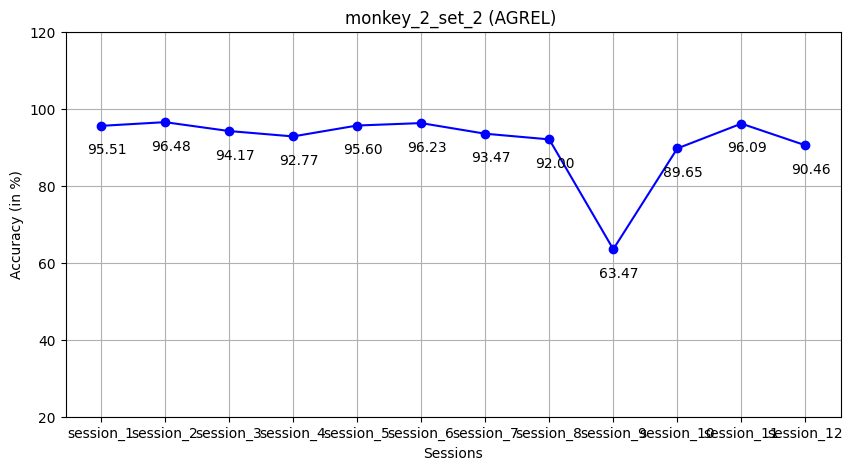

In [27]:
# Evaluating the AGREL Algorithm
directory = dir
files = os.listdir(directory)
acc = []
alpha = 0.1
beta = 0.1
gamma = 0.02
num_nodes=[1000,4]   # Hidden Layer Node sizes

for file in files:
    data = loadmat(os.path.join(directory,file))
    feature_mat = data["feature_mat"]
    X = feature_mat[:,:-1]
    y = feature_mat[:,-1]//90
    num_nodes=[75,4]   # Hidden Layer Node sizes
    num_nodes.insert(0,X.shape[1])
    pred = AGREL(X, y, gamma, alpha, beta, num_nodes, error, sparsity_rate)
    results = np.vstack([y*90,np.array(pred)*90]).T
    results_df = pd.DataFrame(results,columns=["True","Pred"])
    acc.append((np.sum(results_df.loc[:,"True"] == results_df.loc[:,"Pred"])/results_df.shape[0])*100)

acc_AGREL = acc
plt.figure(figsize=(10,5))
plt.plot(range(1,len(files)+1),acc,'b-o')
plt.grid()
plt.ylim((20,120))
plt.ylabel('Accuracy (in %)')
plt.xlabel('Sessions')
plt.xticks(range(1,len(files)+1), labels=['session_'+str(i) for i in range(1,len(files)+1)])
for x,y in zip(range(1,len(files)+1),acc):
    label = "{:.2f}".format(y)
    plt.annotate(label, # this is the text
                 (x,y), # these are the coordinates to position the label
                 textcoords="offset points", # how to position the text
                 xytext=(-10,-20)) # distance from text to points (x,y)
                 
plt.title(directory.split('/')[-1]+' (AGREL) ')
plt.show()
print(np.mean(acc_AGREL))

In [28]:
# Evaluating the Q-Learning Algorithm
directory = dir
files = os.listdir(directory)
acc = []
exec_times_DQN = []
epsilon = 0.01    # Exploration rate
gamma = 0.1       # Discount Factor

for file in files:
    data = loadmat(os.path.join(directory,file))
    feature_mat = data["feature_mat"]
    X = feature_mat[:,:-1]
    y = feature_mat[:,-1]//90
    target = to_categorical(y,4)
    start = time.time()
    pred = DQN(X,target,epsilon,gamma,error,sparsity_rate)
    end = time.time()
    exec_times_DQN.append(round(((end-start)*1e3/X.shape[0]),2))
    results = np.vstack([y*90,np.array(pred)*90]).T
    results_df = pd.DataFrame(results,columns=["True","Pred"])
    acc.append((np.sum(results_df.loc[:,"True"] == results_df.loc[:,"Pred"])/results_df.shape[0])*100)

acc_DQN = acc
plt.figure(figsize=(10,5))
plt.plot(range(1,len(files)+1),acc,'b-o')
plt.grid()
plt.ylim((20,120))
plt.ylabel('Accuracy (in %)')
plt.xlabel('Sessions')
plt.xticks(range(1,len(files)+1), labels=['session_'+str(i) for i in range(1,len(files)+1)])
for x,y in zip(range(1,len(files)+1),acc):
    label = "{:.2f}".format(y)
    plt.annotate(label, # this is the text
                 (x,y), # these are the coordinates to position the label
                 textcoords="offset points", # how to position the text
                 xytext=(-10,-20)) # distance from text to points (x,y)
                 
plt.title(directory.split('/')[-1]+' (Deep Q-Learning) ')
plt.show()
print(np.mean(acc_DQN))

1/1 [==============================] - 0s 22ms/step


KeyboardInterrupt: ignored

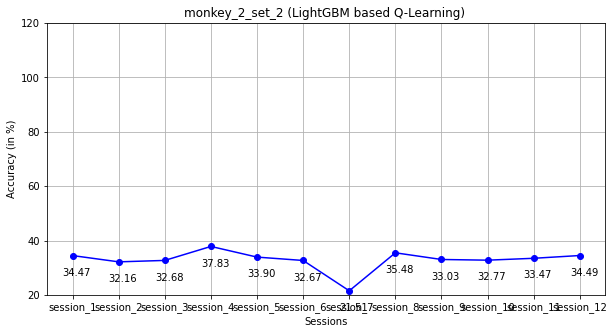

In [ ]:
# Evaluating the QLGBM Algorithm
directory = dir
files = os.listdir(directory)
acc = []
exec_times_QLGBM = []

for file in files:
    data = loadmat(os.path.join(directory,file))
    feature_mat = data["feature_mat"]
    X = feature_mat[:,:-1]
    y = feature_mat[:,-1]//90
    target = to_categorical(y,4)
    start = time.time()
    pred = QLGBM(X,target,epsilon,gamma,error,sparsity_rate)
    end = time.time()
    exec_times_QLGBM.append(round(((end-start)*1e3/(X.shape[0]-1)),2))
    results = np.vstack([y[:-1]*90,np.array(pred)*90]).T
    results_df = pd.DataFrame(results,columns=["True","Pred"])
    acc.append((np.sum(results_df.loc[:,"True"] == results_df.loc[:,"Pred"])/results_df.shape[0])*100)

acc_QLGBM = acc
plt.figure(figsize=(10,5))
plt.plot(range(1,len(files)+1),acc,'b-o')
plt.grid()
plt.ylim((20,120))
plt.ylabel('Accuracy (in %)')
plt.xlabel('Sessions')
plt.xticks(range(1,len(files)+1), labels=['session_'+str(i) for i in range(1,len(files)+1)])
for x,y in zip(range(1,len(files)+1),acc):
    label = "{:.2f}".format(y)
    plt.annotate(label, # this is the text
                 (x,y), # these are the coordinates to position the label
                 textcoords="offset points", # how to position the text
                 xytext=(-10,-20)) # distance from text to points (x,y)
                 
plt.title(directory.split('/')[-1]+' (LightGBM based Q-Learning) ')
plt.show()

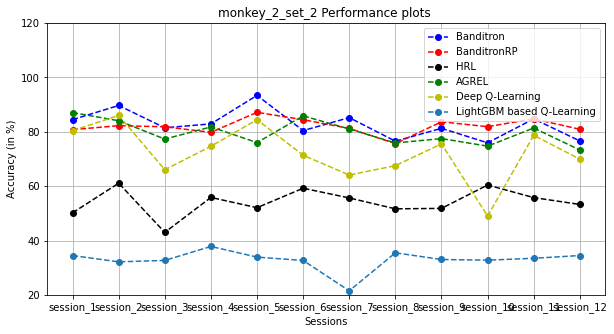

In [ ]:
# Plotting the Decoding accuracy of all the Algorithms
plt.figure(figsize=(10,5))

plt.plot(range(1,len(files)+1),acc_Banditron,'b--o')
plt.plot(range(1,len(files)+1),acc_BanditronRP,'r--o')
plt.plot(range(1,len(files)+1),acc_HRL,'k--o')
plt.plot(range(1,len(files)+1),acc_AGREL,'g--o')
plt.plot(range(1,len(files)+1),acc_DQN,'y--o')
plt.plot(range(1,len(files)+1),acc_QLGBM,'--o')

plt.legend(['Banditron','BanditronRP','HRL','AGREL','Deep Q-Learning','LightGBM based Q-Learning'])

plt.grid()
plt.ylim((20,120))
plt.ylabel('Accuracy (in %)')
plt.xlabel('Sessions')
plt.xticks(range(1,len(files)+1), labels=['session_'+str(i) for i in range(1,len(files)+1)])
                 
plt.title(directory.split('/')[-1]+' Performance plots ')
#plt.savefig(directory.split('/')[-1]+' Performance plots.jpg')
plt.show()

In [ ]:
acc_df = pd.DataFrame([acc_Banditron,acc_BanditronRP,acc_HRL,acc_AGREL,acc_DQN,acc_QLGBM]).T
acc_df.rename(dict(enumerate(['Banditron','BanditronRP','HRL','AGREL','Deep Q-Learning','QLGBM'])),axis=1,inplace=True)
acc_df

,Banditron,BanditronRP,HRL,AGREL,Deep Q-Learning,QLGBM
0,84.489796,80.816327,50.204082,87.074830,80.408163,34.468665
1,89.686684,82.245431,61.096606,84.073107,86.031332,32.156863
2,81.476684,81.865285,43.005181,77.331606,66.062176,32.684825
3,82.917706,79.800499,55.860349,81.795511,74.688279,37.827715
4,93.398533,87.163814,52.078240,76.039120,84.474328,33.904529
5,80.447585,84.452297,59.246172,85.865724,71.378092,32.665094
6,85.222121,81.233001,55.666364,81.051677,64.097915,21.506352
7,76.555556,75.666667,51.666667,75.888889,67.555556,35.483871
8,81.278539,83.675799,51.826484,77.511416,75.570776,33.028571
9,75.951294,81.887367,60.426180,74.733638,49.010654,32.774390


In [ ]:
# For taking out the accuracy data
acc_df.to_csv(directory.split('/')[-1]+' Accuracies_0.75_sparse_feedback.csv')

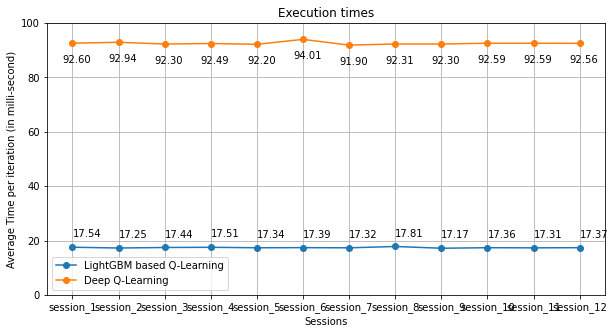

In [ ]:
# Comparing the execution time of DQN and QLGBM
plt.figure(figsize=(10,5))

plt.plot(range(1,len(files)+1),exec_times_QLGBM,'-o')
for x,y in zip(range(1,len(files)+1),exec_times_QLGBM):
    label = "{:.2f}".format(y)
    plt.annotate(label, # this is the text
                 (x,y), # these are the coordinates to position the label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10)) # distance from text to points (x,y)
  
plt.plot(range(1,len(files)+1),exec_times_DQN,'-o')
for x,y in zip(range(1,len(files)+1),exec_times_DQN):
    label = "{:.2f}".format(y)
    plt.annotate(label, # this is the text
                 (x,y), # these are the coordinates to position the label
                 textcoords="offset points", # how to position the text
                 xytext=(-10,-20)) # distance from text to points (x,y)
  
plt.ylim([0,100])
plt.grid()
plt.ylabel('Average Time per iteration (in milli-second)')
plt.xlabel('Sessions')
plt.xticks(range(1,len(files)+1), labels=['session_'+str(i) for i in range(1,len(files)+1)])
plt.title('Execution times')
plt.legend(['LightGBM based Q-Learning','Deep Q-Learning'])
plt.savefig(directory.split('/')[-1] + 'Execution times.jpg')
plt.show()